In [2]:
import os, math, gc
from typing import List, Tuple

import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import CLIPModel, CLIPProcessor

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


'cuda'

In [3]:
MODEL_NAME = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(MODEL_NAME)
model = CLIPModel.from_pretrained(MODEL_NAME).to(DEVICE)
model.eval()

for p in model.parameters():
    p.requires_grad = False

MODEL_NAME


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


'openai/clip-vit-base-patch32'

In [4]:
ds = load_dataset("Hamdy20002/COCO_Person")
print("Available splits:", ds.keys())
split_ds = ds["train"].train_test_split(test_size=0.1, seed=42)
train_ds, val_ds = split_ds["train"], split_ds["test"]


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00005.parquet:   0%|          | 0.00/414M [00:00<?, ?B/s]

data/train-00001-of-00005.parquet:   0%|          | 0.00/415M [00:00<?, ?B/s]

data/train-00002-of-00005.parquet:   0%|          | 0.00/416M [00:00<?, ?B/s]

data/train-00003-of-00005.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

data/train-00004-of-00005.parquet:   0%|          | 0.00/412M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40000 [00:00<?, ? examples/s]

Available splits: dict_keys(['train'])


In [6]:
SUBSET_SIZE = 1000
use_ds = val_ds

if len(use_ds) > SUBSET_SIZE:
    subset = use_ds.select(range(SUBSET_SIZE))
else:
    subset = use_ds

from PIL import Image

images = []
all_captions = []
for idx, row in enumerate(subset):
    img = row["image"].convert("RGB")
    images.append(img)
    for cap in row["text"]:
        if isinstance(cap, str) and cap.strip():
            all_captions.append((cap.strip(), idx))

len(images), len(all_captions), (all_captions[0] if all_captions else None)



(1000, 42894, ('A', 0))

In [7]:
@torch.no_grad()
def encode_images(img_list: List[Image.Image], batch_size: int = 32) -> torch.Tensor:
    """Trả về tensor (N, D), đã L2-normalized theo dòng."""
    feats = []
    for i in tqdm(range(0, len(img_list), batch_size), desc="Encoding images"):
        batch = img_list[i:i+batch_size]
        inputs = processor(images=batch, return_tensors="pt", padding=True).to(DEVICE)
        image_features = model.get_image_features(**inputs)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        feats.append(image_features.detach().cpu())
    return torch.cat(feats, dim=0)

@torch.no_grad()
def encode_text(texts: List[str], batch_size: int = 64) -> torch.Tensor:
    """Trả về tensor (M, D), đã L2-normalized theo dòng."""
    feats = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Encoding texts"):
        batch = texts[i:i+batch_size]
        inputs = processor(text=batch, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
        text_features = model.get_text_features(**inputs)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        feats.append(text_features.detach().cpu())
    return torch.cat(feats, dim=0)


In [8]:
image_index = encode_images(images, batch_size=32)   # (N, D)
image_index.shape


Encoding images: 100%|██████████| 32/32 [00:10<00:00,  3.16it/s]


torch.Size([1000, 512])

Encoding texts: 100%|██████████| 1/1 [00:00<00:00, 76.03it/s]



Query: a red bus on the street
['(idx=917, s=0.316)', '(idx=150, s=0.308)', '(idx=688, s=0.295)', '(idx=79, s=0.294)', '(idx=372, s=0.294)', '(idx=586, s=0.287)']


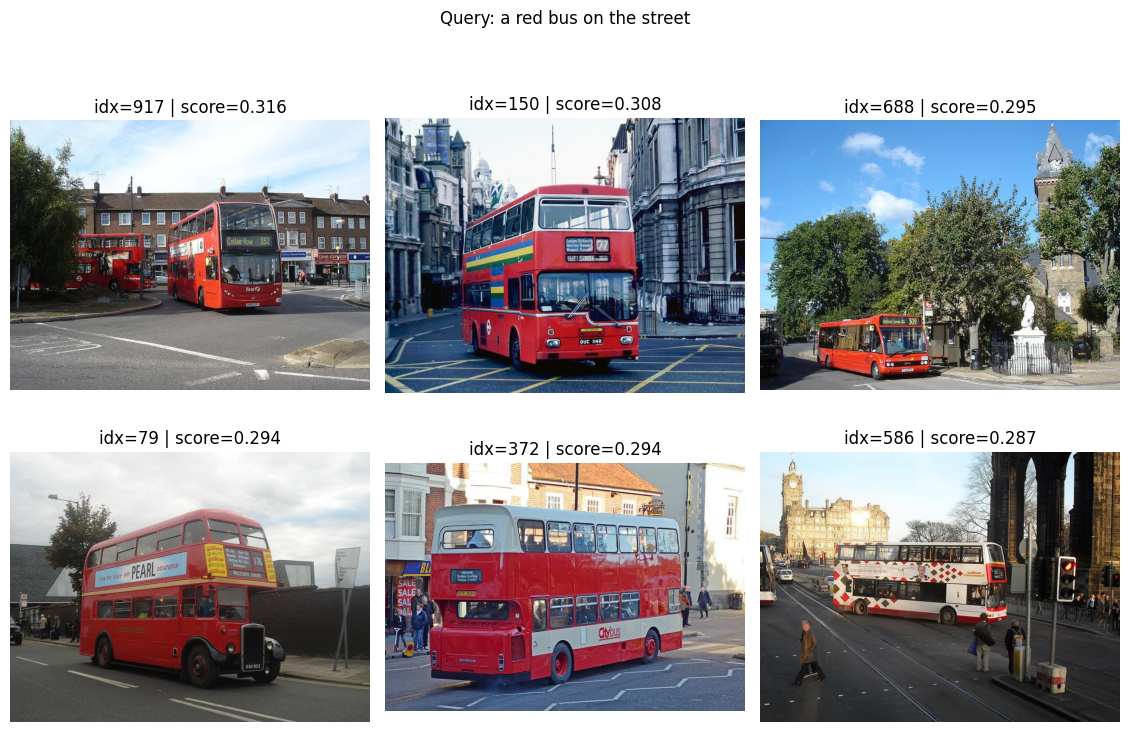

Encoding texts: 100%|██████████| 1/1 [00:00<00:00, 74.27it/s]



Query: a plate of sushi
['(idx=353, s=0.242)', '(idx=956, s=0.236)', '(idx=694, s=0.233)', '(idx=165, s=0.230)', '(idx=429, s=0.227)', '(idx=864, s=0.222)']


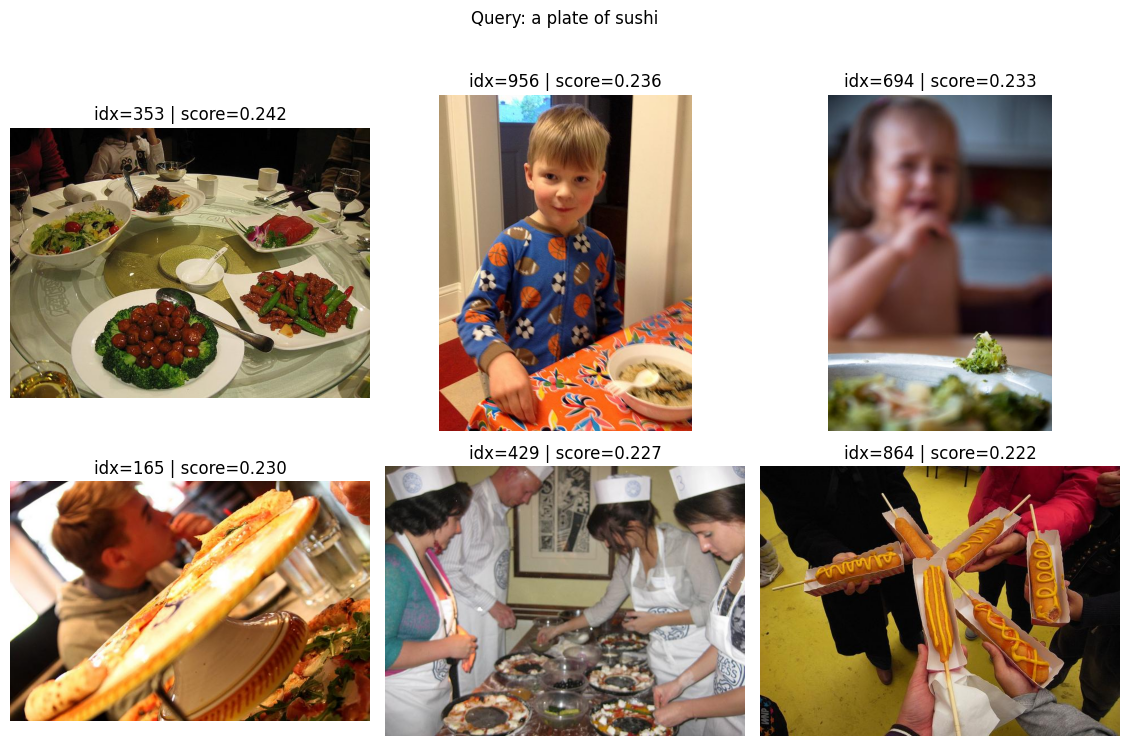

Encoding texts: 100%|██████████| 1/1 [00:00<00:00, 68.78it/s]



Query: a person ride a bike on street
['(idx=618, s=0.309)', '(idx=574, s=0.302)', '(idx=561, s=0.300)', '(idx=201, s=0.292)', '(idx=562, s=0.287)', '(idx=659, s=0.285)']


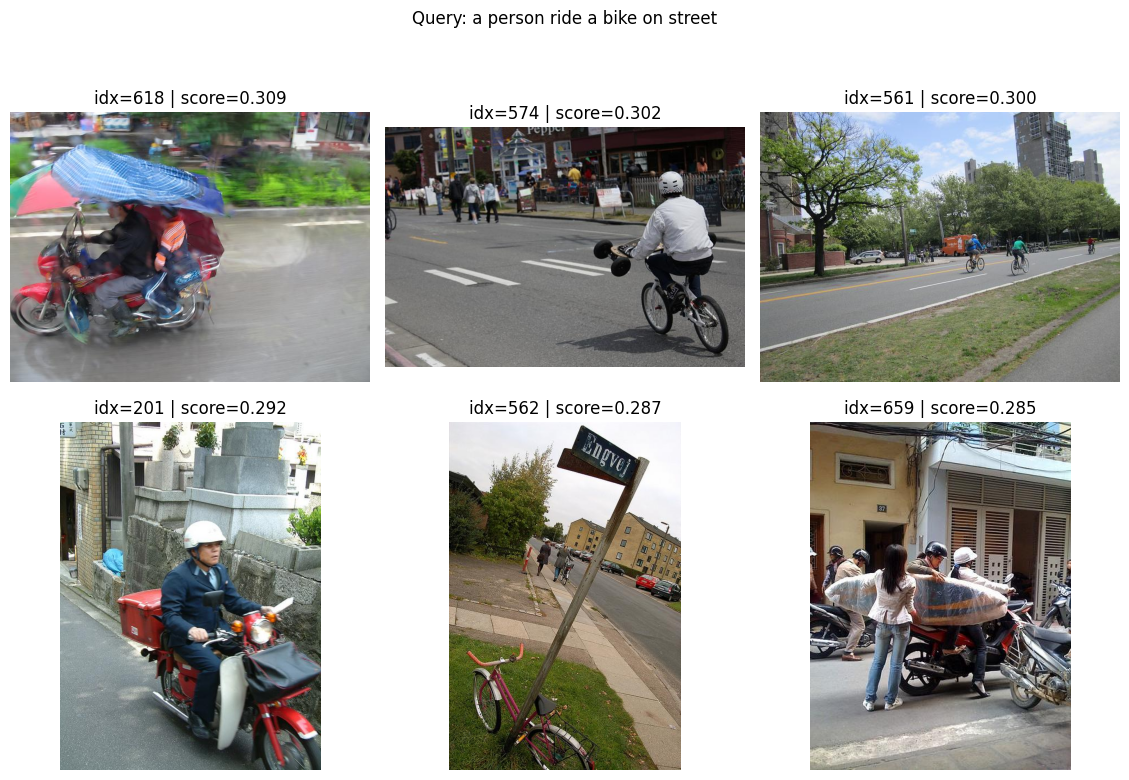

In [11]:
def search(query: str, top_k: int = 6):
    q = encode_text([query], batch_size=1)
    sims = (image_index @ q.T).squeeze(1).numpy()
    top_idx = np.argsort(-sims)[:top_k]
    return [(top_idx[i], float(sims[top_idx[i]])) for i in range(len(top_idx))]

def show_results(results, cols=3, title=""):
    cols = max(1, cols)
    rows = math.ceil(len(results) / cols)
    plt.figure(figsize=(3.8*cols, 3.8*rows))
    for i, (idx, score) in enumerate(results, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(images[idx])
        plt.title(f"idx={idx} | score={score:.3f}")
        plt.axis("off")
    if title:
        plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

queries = [
    "a red bus on the street",
    "a plate of sushi",
    "a person ride a bike on street"
]

for q in queries:
    res = search(q, top_k=6)
    print(f"\nQuery: {q}")
    print([f"(idx={i}, s={s:.3f})" for i,s in res])
    show_results(res, cols=3, title=f"Query: {q}")
